<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/uda_l08_forecast_machinelearning_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

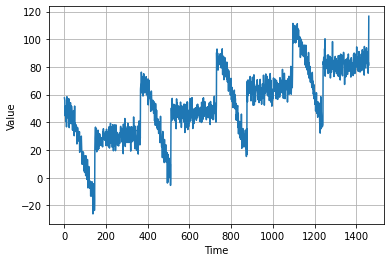

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


#Function to plot the time series graph.
def plot_series(time,series,start=0,end=None,format="_",label=None):
    plt.plot(time[start:end],series[start:end])
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#Funtion to create trend in data for Y-axis
def trend(time,slope):
    return time*slope

#Create X-axis values
time=np.arange(4*365+1)
#Baseline value
baseline=10
#Create y-axis values
series=baseline+trend(time,0.1)

#Plot the graph
plot_series(time,series)
#plt.show()

#apply Cosine for the values less than 0.4 and apply exponetial to the values grater than or equal to 0.4
def seasonal_pattern(season_tme):
    return np.where(season_tme<0.4,np.cos(season_tme*2*np.pi),1/np.exp(3*season_tme))

#Generate series values by converting values of time data set to be between 0 and 1 and by applying seasonal_pattern function.
def seasonality(time,period=365,amplitude=1,phase=0):
    season_time=(((time+phase)%period)/period)
    return amplitude*seasonal_pattern(season_time)

series=seasonality(time,period=365,amplitude=40,phase=0)

plot_series(time,series)
#plt.show()

# let's create a series to include both tern and seasonality
series=baseline+trend(time,slope=0.05)+seasonality(time,period=365,amplitude=40,phase=0)
plot_series(time,series)
#plt.show()

#generate noise for each element in time dataset
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(None)
    return rnd.randn(len(time))*noise_level


noise_level=5
noise = white_noise(time,noise_level=5)
plot_series(time,noise)
#plt.show()

plt.clf()
#Now add the noise to the time series
series=series+noise
plot_series(time,series)
#plt.show()

In [2]:
dataset=tf.data.Dataset.from_tensor_slices(series)
dataset=dataset.window(31,shift=1,drop_remainder=True)

In [3]:
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

57.664627288005946 56.63506237230245 55.9509132809882 44.724717689208546 51.44712863273749 51.65408295180985 51.781529260451464 45.160786208936095 40.67806021290808 48.77099965327807 36.74183236034314 50.600654306081566 58.50041495419474 51.78520614433658 44.65922407600644 47.2176262717276 48.29239039460115 57.01741334563331 50.91864184412935 42.85467388931143 50.560906225406725 49.986839586464605 56.93234286470428 36.177547753085264 49.991285476849896 42.72724403425708 44.50343276061855 47.483778744592165 43.64975223119912 54.22283239587835 47.63270487556625 
56.63506237230245 55.9509132809882 44.724717689208546 51.44712863273749 51.65408295180985 51.781529260451464 45.160786208936095 40.67806021290808 48.77099965327807 36.74183236034314 50.600654306081566 58.50041495419474 51.78520614433658 44.65922407600644 47.2176262717276 48.29239039460115 57.01741334563331 50.91864184412935 42.85467388931143 50.560906225406725 49.986839586464605 56.93234286470428 36.177547753085264 49.99128547684

In [4]:
tupl=lambda window: window.batch(31)
dataset = dataset.flat_map(tupl)
splt=lambda window: (window[:-1],window[-1:])
dataset=dataset.map(splt)

In [5]:
dataset=dataset.shuffle(buffer_size=2)


In [6]:
dataset=dataset.batch(10).prefetch(1)

In [9]:
#create a function with all the above code to prepare data for machine learning algorithm.
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:
split_time = 1000
train_time=time[:split_time]
valid_time=time[split_time:]
train_series=series[:split_time]
valid_series=series[split_time:]

In [14]:
window_size=30
train_data=window_dataset(train_series,window_size)
valid_data=window_dataset(valid_series,window_size)


In [31]:
keras.backend.clear_session()

In [32]:
model=tf.keras.Sequential([tf.keras.layers.Dense(1,input_shape=[window_size])])

In [33]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),loss=keras.losses.Huber(),metrics=["mae"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(train_data,epochs=100,validation_data=valid_data)

Epoch 1/100
31/31 [==============================] - 0s 8ms/step - loss: 9.4126 - mae: 9.9008 - val_loss: 11.4234 - val_mae: 11.9146
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 7.5873 - mae: 8.0748 - val_loss: 9.2780 - val_mae: 9.7742
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 8.1095 - mae: 8.5974 - val_loss: 6.6327 - val_mae: 7.1150
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 6.4345 - mae: 6.9160 - val_loss: 5.8274 - val_mae: 6.3103
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 6.4889 - mae: 6.9725 - val_loss: 7.1001 - val_mae: 7.5862
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 6.0234 - mae: 6.5054 - val_loss: 6.3396 - val_mae: 6.8263
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 5.7012 - mae: 6.1863 - val_loss: 7.4681 - val_mae: 7.9576
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 5.4685 -

In [45]:
def model_forecast(model,series,window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(size=window_size, shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  lin_forecast=model.predict(dataset)
  return lin_forecast

In [46]:
lin_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)

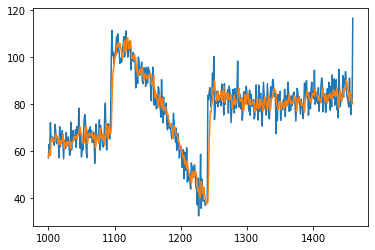

In [50]:
plt.plot(valid_time,valid_series)
plt.plot(valid_time,lin_forecast)
plt.show()